In [122]:
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import stats
import plotly.express as px
import numpy as np
import operator
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS
from sklearn.manifold import TSNE
import umap.umap_ as umap
import random
import itertools
import os 
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


## Daten einlesen

In [123]:
path='./data/'
image_path = './images_clustering/interpolation/'

In [124]:
df = pd.read_csv(path+'/Daten_COPRA_all_subset_80.csv', error_bad_lines=False, warn_bad_lines=False, sep = ';', parse_dates=['Zeitstempel'])

In [125]:
days_interval = 5
test_pat = random.choice(sorted(df.FallNr.unique()))
list_patients = df.FallNr.unique()

#### Vitalwerte

In [126]:
filename = 'X_vital_all_inter_294_35.txt'
X_vital_inter = np.loadtxt(filename).reshape(int(filename.split('_')[-2]),int(filename.split('_')[-1].split('.')[0]))

In [127]:
filename = 'X_vital_all_hour_inter_294_840.txt'
X_vital_hour_inter = np.loadtxt(filename).reshape(int(filename.split('_')[-2]),int(filename.split('_')[-1].split('.')[0]))

#### Laborwerte

In [128]:
filename = 'X_labor_all_inter_294_1845.txt'
X_labor_inter = np.loadtxt(filename).reshape(int(filename.split('_')[-2]),int(filename.split('_')[-1].split('.')[0]))

<a class="anchor" id="numcluster"></a>

# Analysis

## How many clusters?

### Labor

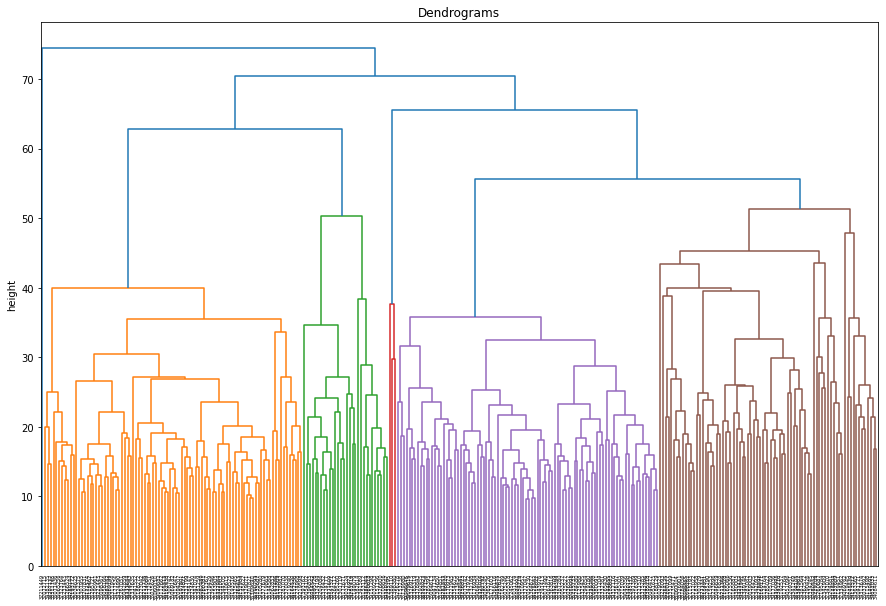

In [8]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_labor_inter, method='ward'), labels=sorted(df.FallNr.unique()))
plt.ylabel('height')
plt.savefig(image_path+'dendrogram_labor_inter.png')

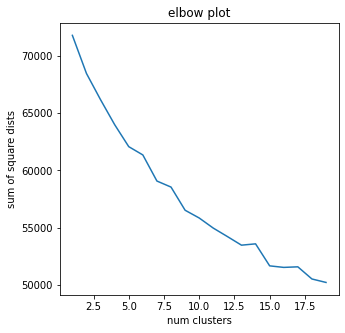

<Figure size 432x288 with 0 Axes>

In [9]:
sum_dist = []
for i in range(1,20):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(X_labor_inter)
    sum_dist.append(model.inertia_)
plt.figure(figsize=(5,5))
plt.plot(range(1,20), sum_dist)
plt.xlabel('num clusters')
plt.ylabel('sum of square dists')
plt.title('elbow plot')
plt.show()
plt.savefig(image_path+'elbow_labor_inter.png')

### Vital

X_vital

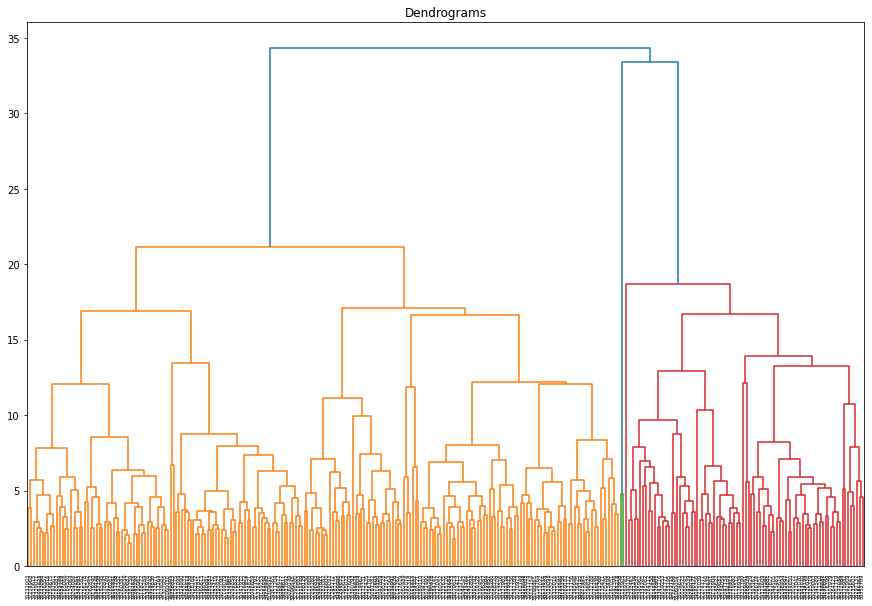

In [76]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_vital_inter, method='ward'), labels=sorted(list_patients))
plt.savefig(image_path+'dendrogram_vital_inter.png')

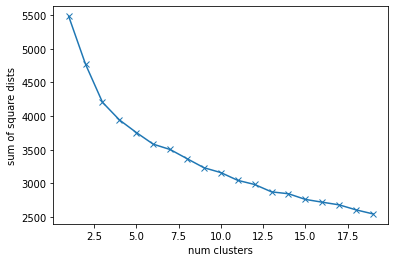

<Figure size 432x288 with 0 Axes>

In [77]:
sum_dist = []
for i in range(1,20):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(X_vital_inter)
    sum_dist.append(model.inertia_)
plt.plot(range(1,20), sum_dist, 'x-')
plt.xlabel('num clusters')
plt.ylabel('sum of square dists')
plt.show()
plt.savefig(image_path+'elbow_vital_inter_' + '.png')

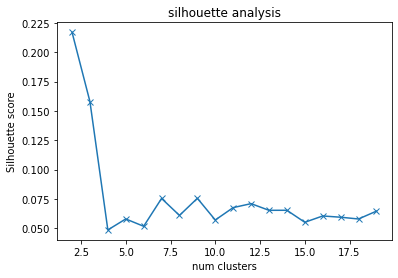

In [78]:
sil_list = []
for n in range(2,20):
    gmm = GaussianMixture(n, covariance_type='full').fit(X_vital_inter)
    predict = gmm.predict(X_vital_inter)
    sil_list.append(silhouette_score(X_vital_inter, predict))

    
plt.plot(range(2,20), sil_list, 'x-')
plt.xlabel('num clusters') 
plt.ylabel('Silhouette score') 
plt.title('silhouette analysis')
plt.show()

 X_vital_hour

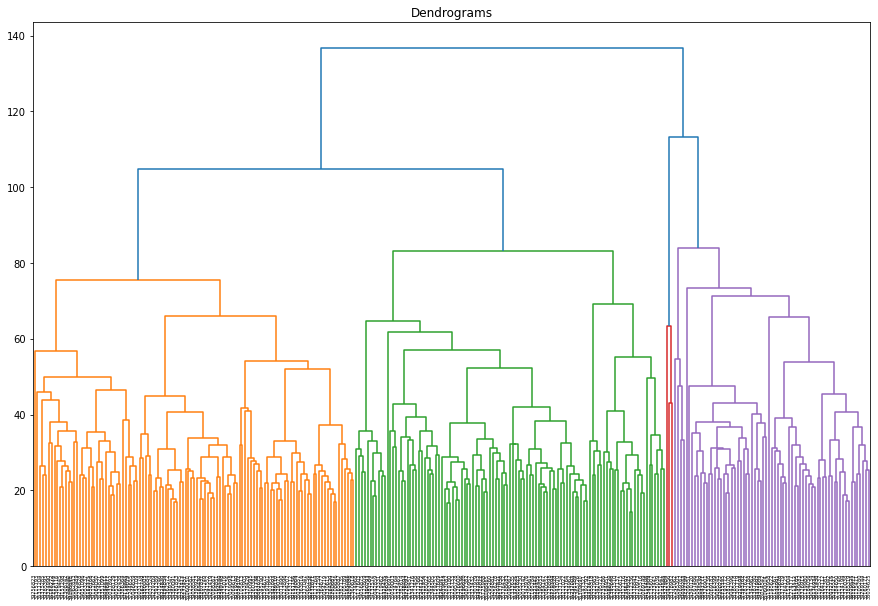

In [70]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_vital_hour_inter, method='ward'), labels=sorted(list_patients))
plt.savefig(image_path+'dendrogram_vital_inter.png')

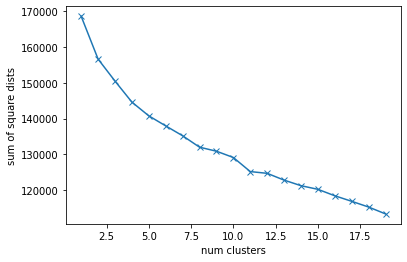

<Figure size 432x288 with 0 Axes>

In [71]:
sum_dist = []
for i in range(1,20):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(X_vital_hour_inter)
    sum_dist.append(model.inertia_)
plt.plot(range(1,20), sum_dist, 'x-')
plt.xlabel('num clusters')
plt.ylabel('sum of square dists')
plt.show()
plt.savefig(image_path+'elbow_vital_hour_inter.png')

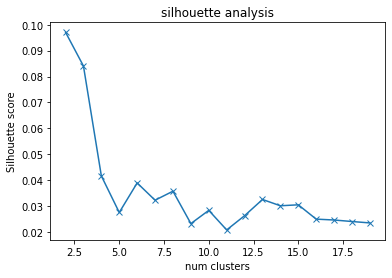

In [72]:
sil_list = []
for n in range(2,20):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_vital_hour_inter)
    
    sil_list.append(silhouette_score(X_vital_hour_inter, kmeans.labels_))

    
plt.plot(range(2,20), sil_list, 'x-')
plt.xlabel('num clusters') 
plt.ylabel('Silhouette score') 
plt.title('silhouette analysis')
plt.show()

## Dimensionality Reduction

### PCA

In [14]:
def pca_components_names(pca_comp, ident_list, days_interval, hour=False):
    if hour == False:
        n_pcs = pca_comp.components_.shape[0]
        most_important = [np.abs(pca_comp.components_[i]).argmax() for i in range(n_pcs)]

        temp1 = list(itertools.chain.from_iterable(itertools.repeat(x, days_interval) for x in ident_list))
        temp2 = list(range(1,days_interval+1))*len(temp1)
        initial_feature_names = [m+'_'+str(n) for m,n in zip(temp1, temp2)]
        most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

        dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

        df_pca = pd.DataFrame(dic.items())
    else:
        n_pcs = pca_comp.components_.shape[0]
        most_important = [np.abs(pca_comp.components_[i]).argmax() for i in range(n_pcs)]
        temp1 = list(itertools.chain.from_iterable(itertools.repeat(x, days_interval*24) for x in ident_list))
        temp2 = list(range(1,days_interval+1))*len(ident_list)*24
        temp3 = list(range(0,24))*days_interval*len(ident_list)
        initial_feature_names = [m+'_day-'+str(n)+'_hour-'+str(o) for m,n,o in zip(temp1, temp2, temp3)]
        most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

        dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

        df_pca = pd.DataFrame(dic.items())
        
    return df_pca, most_important_names

In [15]:
pca_labor_inter = PCA(n_components=2)
pca_data_labor_inter = pca_labor_inter.fit_transform(X_labor_inter)

In [79]:
pca_vital_inter = PCA(n_components=2).fit(X_vital_inter)
pca_data_vital_inter =  pca_vital_inter.transform(X_vital_inter)

pca_vital_hour_inter = PCA(n_components=2).fit(X_vital_hour_inter)
pca_data_vital_hour_inter =  pca_vital_hour_inter.transform(X_vital_hour_inter)

In [80]:
cat = 'Vitalwert'
ident_list = list(df[df.Kategorie==cat]['Wertbezeichner'].unique())
df_pca_vital_inter, vital_pca_names_list_inter = pca_components_names(pca_vital_inter, ident_list, days_interval, hour=False)
print(df_pca_vital_inter.values)
# wieviel erklären die achsen insgesamt an varianz 
print(np.array2string(pca_vital_inter.explained_variance_))
print(np.array2string(pca_vital_inter.explained_variance_ratio_))

[['PC0' 'RR_3']
 ['PC1' 'SPO2_5']]
[3.91125221 2.68202054]
[0.20904254 0.14334448]


In [81]:
cat = 'Labor'
ident_list = list(df[df.Kategorie==cat]['Wertbezeichner'].unique())
df_pca_labor_inter, labor_pca_names_list_inter = pca_components_names(pca_labor_inter, ident_list, days_interval, hour=False)
print(df_pca_labor_inter.values)
# wieviel erklären die achsen insgesamt an varianz 
print(np.array2string(pca_labor_inter.explained_variance_))
print(np.array2string(pca_labor_inter.explained_variance_ratio_))

[['PC0' 'HIT-II OD_1']
 ['PC1' 'Troponin-Ths_1']]
[17.32513212 14.25081308]
[0.07072902 0.05817826]


In [82]:
cat = 'Vitalwert'
ident_list = list(df[df.Kategorie==cat]['Wertbezeichner'].unique())
df_pca_vital_hour_inter, vital_hour_pca_names_list_inter = pca_components_names(pca_vital_hour_inter, ident_list, days_interval, hour=True)
print(df_pca_vital_hour_inter.values)
# wieviel erklären die achsen insgesamt an varianz 
print(np.array2string(pca_vital_hour_inter.explained_variance_))
print(np.array2string(pca_vital_hour_inter.explained_variance_ratio_))

[['PC0' 'HF_day-1_hour-2']
 ['PC1' 'ICP_day-4_hour-8']]
[60.69779273 47.31284323]
[0.10547893 0.08221894]


In [20]:
#  welche features tragen zu den beiden achsen jeweils wie stark bei
(pca_vital_inter.components_.T * np.sqrt(pca_vital_inter.explained_variance_ratio_)).max()

0.17940173613399063

### UMAP

In [21]:
reducer = umap.UMAP()
umap_data_labor_inter = reducer.fit_transform(X_labor_inter)

In [22]:
reducer = umap.UMAP()
umap_data_vital_inter = reducer.fit_transform(X_vital_inter)

In [23]:
reducer = umap.UMAP()
umap_data_vital_hour_inter = reducer.fit_transform(X_vital_hour_inter)

# Clustering

## Labor
<a class="anchor" id="labor"></a>

#### Hierarchical Clustering

In [101]:
cluster_pca_labor_inter = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
cluster_pca_labor_inter.fit_predict(pca_data_labor_inter)
fig = go.Figure([go.Scatter(x=pca_data_labor_inter[:,0], 
                            y=pca_data_labor_inter[:,1], 
                            marker={'color':cluster_pca_labor_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#FFFFFF', '#5274e3', '#00CC96', '#5274e3', '#5274e3', '#e86bc1', '#B6E880', '#FF97FF', '#e88820'])])
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_labor_inter.values[0,1])+','+str("{:6.2f}".format(pca_labor_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_labor_inter.values[1,1])+','+str("{:6.2f}".format(pca_labor_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'cluster_labor_inter_pca.png')

fig.write_html(image_path+'cluster_labor_inter_pca.html')

In [102]:
cluster_umap_labor_inter = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
cluster_umap_labor_inter.fit_predict(umap_data_labor_inter)
fig = go.Figure([go.Scatter(x=umap_data_labor_inter[:,0], 
                            y=umap_data_labor_inter[:,1], 
                            marker={'color':cluster_umap_labor_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#FFFFFF', '#5274e3', '#00CC96', '#5274e3', '#5274e3', '#e86bc1', '#B6E880', '#FF97FF', '#e88820'])])
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450)
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'cluster_labor_inter_umap.png')
fig.write_html(image_path+'cluster_labor_inter_umap.html')

#### k-means

In [103]:
kmeans_pca_labor_inter = KMeans(n_clusters=7, random_state=0).fit(pca_data_labor_inter)
fig = go.Figure([go.Scatter(x=pca_data_labor_inter[:,0], 
                            y=pca_data_labor_inter[:,1], 
                            marker={'color': kmeans_pca_labor_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#FFFFFF', '#5274e3', '#00CC96', '#5274e3', '#5274e3', '#e86bc1', '#B6E880', '#FF97FF', '#e88820'])])
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_labor_inter.values[0,1])+','+str("{:6.2f}".format(pca_labor_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_labor_inter.values[1,1])+','+str("{:6.2f}".format(pca_labor_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')

fig.show()
fig.write_image(image_path+'kmeans_labor_inter_pca.png')
fig.write_html(image_path+'kmeans_labor_inter_pca.html')

In [130]:
kmeans_umap_labor_inter = KMeans(n_clusters=7, random_state=0).fit(umap_data_labor_inter)
fig = go.Figure([go.Scatter(x=umap_data_labor_inter[:,0], 
                            y=umap_data_labor_inter[:,1], 
                            marker={'color': kmeans_umap_labor_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#FFFFFF', '#5274e3', '#00CC96', '#BDC73C', '#BDC73C', '#e86bc1', '#d61529', '#d61529', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=300)
fig.update_layout(plot_bgcolor='#eaeaf2')

fig.show()
fig.write_image(image_path+'kmeans_labor_inter_umap.png')
fig.write_html(image_path+'kmeans_labor_inter_umap.html')

#### GMM

In [105]:
gmm_pca_labor_inter = GaussianMixture(n_components=7, covariance_type='full', random_state=1).fit(pca_data_labor_inter)
labels = gmm_pca_labor_inter.predict(pca_data_labor_inter)
fig = go.Figure([go.Scatter(x=pca_data_labor_inter[:,0], 
                            y=pca_data_labor_inter[:,1], 
                            marker={'color': labels, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#FFFFFF', '#5274e3', '#00CC96', '#5274e3', '#5274e3', '#e86bc1', '#B6E880', '#FF97FF', '#e88820'])])
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_labor_inter.values[0,1])+','+str("{:6.2f}".format(pca_labor_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_labor_inter.values[1,1])+','+str("{:6.2f}".format(pca_labor_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')

fig.show()
fig.write_image(image_path+'gmm_labor_inter_pca.png')

In [106]:
gmm_umap_labor_inter = GaussianMixture(n_components=7, covariance_type='full', random_state=1).fit(umap_data_labor_inter)
labels = gmm_umap_labor_inter.predict(umap_data_labor_inter)
fig = go.Figure([go.Scatter(x=umap_data_labor_inter[:,0], 
                            y=umap_data_labor_inter[:,1], 
                            marker={'color': labels, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#FFFFFF', '#5274e3', '#00CC96', '#5274e3', '#5274e3', '#e86bc1', '#B6E880', '#FF97FF', '#e88820'])])
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450)
fig.update_layout(plot_bgcolor='#eaeaf2')

fig.show()
fig.write_image(image_path+'gmm_labor_inter_umap.png')

## Vital
<a class="anchor" id="vital"></a>

### Vital all (daily)

#### Hierarchical Clustering

In [107]:
cluster_pca_vital_inter = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster_pca_vital_inter.fit_predict(pca_data_vital_inter)
fig = go.Figure([go.Scatter(x=pca_data_vital_inter[:,0], 
                            y=pca_data_vital_inter[:,1], 
                            marker={'color':cluster_pca_vital_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#e86bc1', '#5274e3', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_vital_inter.values[0,1])+','+str("{:6.2f}".format(pca_vital_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_vital_inter.values[1,1])+','+str("{:6.2f}".format(pca_vital_inter.explained_variance_ratio_[1]*100))+'% variance')

fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'cluster_vital_inter_pca.png')
fig.write_html(image_path+'cluster_vital_inter_pca.html')

In [108]:
cluster_umap_vital_inter = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster_umap_vital_inter.fit_predict(umap_data_vital_inter)
fig = go.Figure([go.Scatter(x=umap_data_vital_inter[:,0], 
                            y=umap_data_vital_inter[:,1], 
                            marker={'color':cluster_umap_vital_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#e86bc1', '#5274e3', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450)
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'cluster_vvital_inter_umap.png')
fig.write_html(image_path+'cluster_vvital_inter_umap.html')

#### k-means

In [109]:
kmeans_pca_vital_inter = KMeans(n_clusters=5, random_state=0).fit(pca_data_vital_inter)
fig = go.Figure([go.Scatter(x=pca_data_vital_inter[:,0], 
                            y=pca_data_vital_inter[:,1], 
                            marker={'color': kmeans_pca_vital_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#e86bc1', '#5274e3', '#e88820'])])


fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_vital_inter.values[0,1])+','+str("{:6.2f}".format(pca_vital_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_vital_inter.values[1,1])+','+str("{:6.2f}".format(pca_vital_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'kmeans_vital_inter_pca.png')
fig.write_html(image_path+'kmeans_vital_inter_pca.html')

In [132]:
kmeans_umap_vital_inter = KMeans(n_clusters=5, random_state=0).fit(umap_data_vital_inter)
fig = go.Figure([go.Scatter(x=umap_data_vital_inter[:,0], 
                            y=umap_data_vital_inter[:,1], 
                            marker={'color':kmeans_umap_vital_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#FFFFFF', '#5274e3', '#00CC96', '#BDC73C', '#BDC73C', '#e86bc1', '#d61529', '#d61529', '#e88820'])])


fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=300)
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'kmeans_vital_inter_umap.png')
fig.write_html(image_path+'kmeans_vital_inter_umap.html')

#### GMM

In [111]:
gmm_pca_vital_inter = GaussianMixture(n_components=5, covariance_type='full', random_state=1).fit(pca_data_vital_inter)
labels = gmm_pca_vital_inter.predict(pca_data_vital_inter)
fig = go.Figure([go.Scatter(x=pca_data_vital_inter[:,0], 
                            y=pca_data_vital_inter[:,1], 
                            marker={'color': labels, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#e86bc1', '#5274e3', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_vital_inter.values[0,1])+','+str("{:6.2f}".format(pca_vital_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_vital_inter.values[1,1])+','+str("{:6.2f}".format(pca_vital_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'gmm_vital_inter_pca.png')

In [112]:
gmm_umap_vital_inter = GaussianMixture(n_components=5, covariance_type='full', random_state=1).fit(umap_data_vital_inter)
labels = gmm_umap_vital_inter.predict(umap_data_vital_inter)
fig = go.Figure([go.Scatter(x=umap_data_vital_inter[:,0], 
                            y=umap_data_vital_inter[:,1], 
                            marker={'color': labels, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#e86bc1', '#5274e3', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450)
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'gmm_vital_inter_umap.png')

### Vital all hour

#### Hierarchical Clustering

In [113]:
cluster_pca_vital_hour_inter = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster_pca_vital_hour_inter.fit_predict(pca_data_vital_hour_inter)
fig = go.Figure([go.Scatter(x=pca_data_vital_hour_inter[:,0], 
                            y=pca_data_vital_hour_inter[:,1], 
                            marker={'color':cluster_pca_vital_hour_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#d61529', '#5274e3', '#e88820'])])


fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_vital_hour_inter.values[0,1])+','+str("{:6.2f}".format(pca_vital_hour_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_vital_hour_inter.values[1,1])+','+str("{:6.2f}".format(pca_vital_hour_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'cluster_vital_hour_inter_pca.png')
fig.write_html(image_path+'cluster_vital_hour_inter_pca.html')

In [121]:
cluster_umap_vital_hour_inter = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster_umap_vital_hour_inter.fit_predict(umap_data_vital_hour_inter)
fig = go.Figure([go.Scatter(x=umap_data_vital_hour_inter[:,0], 
                            y=umap_data_vital_hour_inter[:,1], 
                            marker={'color':cluster_umap_vital_hour_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#d61529', '#5274e3', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450)
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'cluster_vital_hour_inter_umap.png')
fig.write_html(image_path+'cluster_vital_hour_inter_umap_height.html')

#### Kmeans


In [115]:
kmeans_pca_vital_hour_inter = KMeans(n_clusters=6, random_state=0).fit(pca_data_vital_hour_inter)
fig = go.Figure([go.Scatter(x=pca_data_vital_hour_inter[:,0], 
                            y=pca_data_vital_hour_inter[:,1], 
                            marker={'color': kmeans_pca_vital_hour_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#d61529', '#5274e3', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_vital_hour_inter.values[0,1])+','+str("{:6.2f}".format(pca_vital_hour_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_vital_hour_inter.values[1,1])+','+str("{:6.2f}".format(pca_vital_hour_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'kmeans_vital_hour_inter_pca.png')
fig.write_html(image_path+'kmeans_vital_hour_inter_pca.html')

In [119]:
kmeans_umap_vital_hour_inter = KMeans(n_clusters=6, random_state=0).fit(umap_data_vital_hour_inter)
fig = go.Figure([go.Scatter(x=umap_data_vital_hour_inter[:,0], 
                            y=umap_data_vital_hour_inter[:,1], 
                            marker={'color':kmeans_umap_vital_hour_inter.labels_, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#d61529', '#5274e3', '#e88820'])])

fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450)
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'kmeans_vital_hour_inter_umap.png')
fig.write_html(image_path+'kmeans_vital_hour_inter_umap.html')

#### GMM

In [117]:
gmm_pca_vital_hour_inter = GaussianMixture(n_components=6, covariance_type='full', random_state=1).fit(pca_data_vital_hour_inter)
labels = gmm_pca_vital_hour_inter.predict(pca_data_vital_hour_inter)
fig = go.Figure([go.Scatter(x=pca_data_vital_hour_inter[:,0], 
                            y=pca_data_vital_hour_inter[:,1], 
                            marker={'color': labels, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#d61529', '#5274e3', '#e88820'])])
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=450,
    xaxis_title="PC1 "+str(df_pca_vital_hour_inter.values[0,1])+','+str("{:6.2f}".format(pca_vital_hour_inter.explained_variance_ratio_[0]*100))+'% variance',
    yaxis_title="PC2 "+str(df_pca_vital_hour_inter.values[1,1])+','+str("{:6.2f}".format(pca_vital_hour_inter.explained_variance_ratio_[1]*100))+'% variance')
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'gmm_vital_hour_inter_pca.png')

In [118]:
gmm_umap_vital_hour_inter = GaussianMixture(n_components=6, covariance_type='full', random_state=1).fit(umap_data_vital_hour_inter)
labels = gmm_umap_vital_hour_inter.predict(umap_data_vital_hour_inter)
fig = go.Figure([go.Scatter(x=umap_data_vital_hour_inter[:,0], 
                            y=umap_data_vital_hour_inter[:,1], 
                            marker={'color': labels, 'size':10}, 
                            mode='markers',
                            text=sorted(df.FallNr.unique()),
                            hovertemplate='%{text}<br><extra></extra>',
                            marker_colorscale=['#1e094c', '#00CC96', '#00CC96', '#00CC96', '#5274e3', '#e86bc1', '#e86bc1', '#d61529', '#5274e3', '#e88820'])])
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=True,
    width=800,
    height=300)
fig.update_layout(plot_bgcolor='#eaeaf2')
fig.show()
fig.write_image(image_path+'gmm_vital_hour_inter_umap_height.png')